In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../../../fastai/")
sys.path.append("../../../fastai/courses/dl1")

from fastai.imports import *
from fastai.transforms  import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from planet import f2

In [2]:
PATH = ''
sz = 224
f_model = resnet34
bs = 128
metrics = [f2]

In [3]:
ls {PATH}

__MACOSX/                                         test-jpg.tar.7z
models/                                           test_v2_file_mapping.csv
planet-understanding-the-amazon-from-space.ipynb  tmp/
README.md                                         train-jpg/
subm/                                             train-jpg.tar
test-jpg/                                         train-jpg.tar.7z
test-jpg-additional.tar                           train_v2.csv
test-jpg-additional.tar.7z                        train_v2.csv.zip
test-jpg.tar


In [4]:
label_csv=f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [5]:
n

40479

In [6]:
label_df=pd.read_csv(label_csv)
label_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [7]:
def get_data(sz):
    tfms = tfms_from_model(f_model,sz,aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms, 
                  suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')
#batch size not set here

In [8]:
data = get_data(256)

In [9]:
fn = PATH+data.trn_ds.fnames[0]; fn

'train-jpg/train_0.jpg'

In [10]:
x,y = next(iter(data.val_dl))

In [11]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

In [12]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

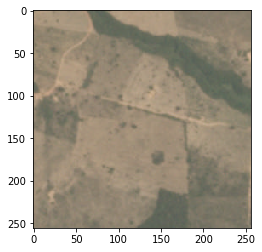

In [13]:
plt.imshow(data.val_ds.denorm(to_np(x))[2]) #??

In [14]:
sz = 64

In [15]:
data = get_data(sz)

In [16]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [17]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

In [61]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.221896   0.287906   0.819854  



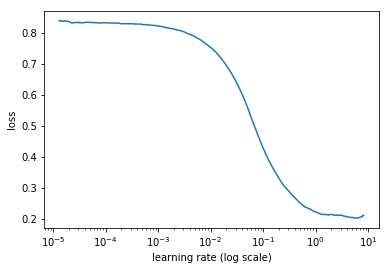

In [62]:
learn.sched.plot()

In [63]:
lr = 0.2

In [64]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.147628   0.135269   0.880635  
    1      0.140822   0.129374   0.888163                    
    2      0.136614   0.128021   0.887616                    
    3      0.13709    0.126979   0.888831                    
    4      0.134639   0.124707   0.89122                     
    5      0.131429   0.122893   0.893343                    
    6      0.129175   0.122936   0.894134                    



[array([ 0.12294]), 0.89413402685928978]

In [65]:
lrs = np.array([lr/9,lr/3,lr])

In [66]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.121399   0.108994   0.90814   
    1      0.118457   0.10609    0.910452                    
    2      0.109281   0.102479   0.913164                    
    3      0.110571   0.104118   0.911414                    
    4      0.105331   0.100572   0.915617                    
    5      0.103131   0.09791    0.918221                     
    6      0.098372   0.098043   0.917724                     



[array([ 0.09804]), 0.91772376683142831]

In [67]:
learn.save(f'{sz}')

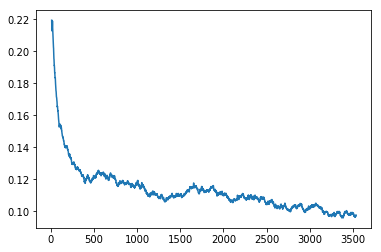

In [68]:
learn.sched.plot_loss()

In [69]:
sz = 128

In [70]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.098979   0.097713   0.916028  
    1      0.099368   0.096293   0.917883                     
    2      0.097903   0.095634   0.918067                     
    3      0.097155   0.095012   0.918818                     
    4      0.094573   0.09494    0.918633                     
    5      0.093701   0.093922   0.920463                     
    6      0.093906   0.093629   0.920697                     



[array([ 0.09363]), 0.9206967552919878]

In [71]:
learn.save(f'{sz}')

In [72]:
learn.unfreeze()
learn.fit(lrs,3,cycle_len=1,cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.094152   0.088627   0.925474  
    1      0.093676   0.089585   0.925932                     
    2      0.087331   0.086828   0.927951                     
    3      0.093626   0.088268   0.926483                     
    4      0.089735   0.087524   0.925985                     
    5      0.086367   0.085279   0.928969                     
    6      0.084408   0.085396   0.928324                     



In [73]:
sz=256
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.090215   0.089775   0.924192  
    1      0.092558   0.089199   0.924909                     
    2      0.089454   0.088412   0.926316                     
    3      0.091798   0.087772   0.927329                     
    4      0.089698   0.087825   0.926984                     
    5      0.086902   0.087495   0.926901                     
    6      0.085364   0.08741    0.926996                     



HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.086914   0.083305   0.931608  
    1      0.08678    0.08368    0.931482                     
    2      0.082876   0.082263   0.932837                     
    3      0.085344   0.085423   0.927952                     
    4      0.084556   0.082843   0.931615                     
    5      0.078763   0.082006   0.931565                     
    6      0.079505   0.08189    0.932217                     



In [18]:
learn.load('256')

In [19]:
multiClassPredictions, target_values = learn.TTA(is_test = True)


In [21]:
predictions = np.mean(multiClassPredictions,0)

In [22]:
predictions.shape

(61191, 17)

In [23]:
df=pd.DataFrame(predictions)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.745971,0.002098,0.010999,0.000344,1.377852e-04,0.954788,0.000029,0.001047,0.220901,0.996896,0.004562,0.005478,0.996028,0.473970,0.000267,0.003214,0.292031
1,0.009092,0.000152,0.002110,0.068261,1.151894e-03,0.982398,0.000089,0.000185,0.010531,0.057560,0.015894,0.000611,0.999343,0.015466,0.035737,0.000465,0.009527
2,0.196842,0.000019,0.000797,0.000037,2.838892e-07,0.994948,0.000002,0.000003,0.002780,0.000056,0.011362,0.000014,0.999789,0.006473,0.000002,0.000037,0.999653
3,0.010274,0.000013,0.001215,0.000273,4.841342e-05,0.998306,0.000049,0.000024,0.000423,0.000202,0.000365,0.001020,0.997086,0.005745,0.000093,0.000063,0.451439
4,0.000397,0.000024,0.000073,0.000929,5.284726e-05,0.008805,0.000075,0.000006,0.000113,0.000082,0.000576,0.973788,0.999844,0.000038,0.000074,0.000023,0.001262


In [24]:
df.columns = data.classes
df.head()

,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,0.745971,0.002098,0.010999,0.000344,1.377852e-04,0.954788,0.000029,0.001047,0.220901,0.996896,0.004562,0.005478,0.996028,0.473970,0.000267,0.003214,0.292031
1,0.009092,0.000152,0.002110,0.068261,1.151894e-03,0.982398,0.000089,0.000185,0.010531,0.057560,0.015894,0.000611,0.999343,0.015466,0.035737,0.000465,0.009527
2,0.196842,0.000019,0.000797,0.000037,2.838892e-07,0.994948,0.000002,0.000003,0.002780,0.000056,0.011362,0.000014,0.999789,0.006473,0.000002,0.000037,0.999653
3,0.010274,0.000013,0.001215,0.000273,4.841342e-05,0.998306,0.000049,0.000024,0.000423,0.000202,0.000365,0.001020,0.997086,0.005745,0.000093,0.000063,0.451439
4,0.000397,0.000024,0.000073,0.000929,5.284726e-05,0.008805,0.000075,0.000006,0.000113,0.000082,0.000576,0.973788,0.999844,0.000038,0.000074,0.000023,0.001262


In [25]:
df.to_feather('tmp/raw')

In [67]:
df=pd.read_feather('tmp/raw')

In [26]:
data.test_ds.fnames
df.insert(0,'image_name',[o[9:-4] for o in data.test_ds.fnames])
df.head()

,image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,test_25202,0.745971,0.002098,0.010999,0.000344,1.377852e-04,0.954788,0.000029,0.001047,0.220901,0.996896,0.004562,0.005478,0.996028,0.473970,0.000267,0.003214,0.292031
1,test_5717,0.009092,0.000152,0.002110,0.068261,1.151894e-03,0.982398,0.000089,0.000185,0.010531,0.057560,0.015894,0.000611,0.999343,0.015466,0.035737,0.000465,0.009527
2,test_40598,0.196842,0.000019,0.000797,0.000037,2.838892e-07,0.994948,0.000002,0.000003,0.002780,0.000056,0.011362,0.000014,0.999789,0.006473,0.000002,0.000037,0.999653
3,file_2096,0.010274,0.000013,0.001215,0.000273,4.841342e-05,0.998306,0.000049,0.000024,0.000423,0.000202,0.000365,0.001020,0.997086,0.005745,0.000093,0.000063,0.451439
4,file_19729,0.000397,0.000024,0.000073,0.000929,5.284726e-05,0.008805,0.000075,0.000006,0.000113,0.000082,0.000576,0.973788,0.999844,0.000038,0.000074,0.000023,0.001262


In [27]:
def applyZeros():
    for x in data.classes:
        df[x].mask(df[x]<0.5,0,inplace=True);
        df[x].mask(df[x]>=0.5,1,inplace=True);
applyZeros()
df.head()

,image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,test_25202,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,test_5717,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,test_40598,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,file_2096,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,file_19729,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
5,file_423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
6,file_401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
7,test_35442,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
8,file_7286,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,test_22859,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
for x in data.classes:
    df[x].replace(to_replace=0,value="",inplace=True)
    df[x].replace(to_replace=1,value=x+" ",inplace=True)
    
df.head()

,image_name,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,test_25202,agriculture,,,,,clear,,,,habitation,,,primary,,,,
1,test_5717,,,,,,clear,,,,,,,primary,,,,
2,test_40598,,,,,,clear,,,,,,,primary,,,,water
3,file_2096,,,,,,clear,,,,,,,primary,,,,
4,file_19729,,,,,,,,,,,,partly_cloudy,primary,,,,


In [29]:
dfTest=df["agriculture"]
for x in data.classes[1:]:
    dfTest += df[x]
dfTest.head()

0    agriculture clear habitation primary 
1                           clear primary 
2                     clear primary water 
3                           clear primary 
4                   partly_cloudy primary 
Name: agriculture, dtype: object

In [30]:
dfTest=dfTest.to_frame()

In [31]:
dfTest.head()

,agriculture
0,agriculture clear habitation primary
1,clear primary
2,clear primary water
3,clear primary
4,partly_cloudy primary


In [32]:
data.test_ds.fnames
dfTest.insert(0,'image_name',[o[9:-4] for o in data.test_ds.fnames])
dfTest.head()

,image_name,agriculture
0,test_25202,agriculture clear habitation primary
1,test_5717,clear primary
2,test_40598,clear primary water
3,file_2096,clear primary
4,file_19729,partly_cloudy primary


In [33]:
dfTest.rename({"agriculture":"tags"},axis='columns',inplace=True)

In [34]:
dfTest.shape

(61191, 2)

In [35]:
#df.to_feather('tmp/raw')
dfTest.to_feather('tmp/dfTest')

In [36]:
dfTest.head()

,image_name,tags
0,test_25202,agriculture clear habitation primary
1,test_5717,clear primary
2,test_40598,clear primary water
3,file_2096,clear primary
4,file_19729,partly_cloudy primary


In [37]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM,exist_ok=True)

In [38]:
dfTest.to_csv(f'{SUBM}subm.gz',compression='gzip', index=False)

In [39]:
FileLink(f'{SUBM}subm.gz')

/home/paperspace/kaggle/competitions/planet-understanding-the-amazon-from-space/subm/subm.gz

In [40]:
dfTest.to_csv(f'{SUBM}subm.csv', index=False)

In [41]:
FileLink(f'{SUBM}subm.csv')

/home/paperspace/kaggle/competitions/planet-understanding-the-amazon-from-space/subm/subm.csv